## Black Friday Sales Prediction

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression,  Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print('Training set has {} rows and {} columns'.format(train.shape[0], train.shape[1]))
print('Testing set {} rows and {} columns'.format(test.shape[0], test.shape[1]))

Training set has 550068 rows and 12 columns
Testing set 233599 rows and 11 columns


In [4]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [5]:
train.isnull().mean()*100

User_ID                        0.000000
Product_ID                     0.000000
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            31.566643
Product_Category_3            69.672659
Purchase                       0.000000
dtype: float64

Product_Categort_2 has 32.6% missing records. Product_Category_3 has 69.7% missing records.

In [6]:
test.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

### Impute missing values

In [7]:
def impute_missing(df):
    
    """impute_missing fills in the missing values
    
    Arg:
        df: pandas dataframe containing features with missing values
        
    Returns:
        df: pandas dataframe without missing values
    """
    missing_cols = [var for var in df.columns if df[var].isnull().sum() > 0]
    for col in missing_cols:
        df[col] = df[col].fillna(9999)
        
    return df

In [8]:
train = impute_missing(train)
test = impute_missing(test)

In [9]:
train_missing = [var for var in train.columns if train[var].isnull().sum() > 0]
test_missing = [var for var in test.columns if test[var].isnull().sum() > 0]

print('Missing values (train set): {}'.format(train_missing))
print('Missing values (test set): {}'.format(test_missing))

Missing values (train set): []
Missing values (test set): []


In [10]:
df = train.copy()

## Univariate data analysis

### Target variable

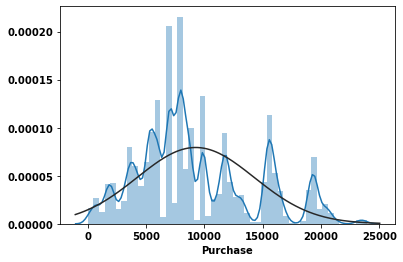

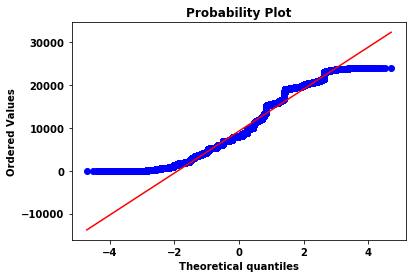

In [12]:
#Histogram
sns.distplot(df['Purchase'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['Purchase'], plot=plt);
plt.savefig('./Images/target.png')

We can see that the target:
- Deviates from normal distribution
- Has positive skewness
- Shows peakedness

In [13]:
#Skewness and Kurtosis
print('Skewness: {}'.format(df['Purchase'].skew()))
print('Kurtosis: {}'.format(df['Purchase'].kurt()))

Skewness: 0.6001400037087128
Kurtosis: -0.3383775655851702


In [14]:
# Dependency of gender on purchase
gender_ = df[['Gender', 'Purchase']].groupby('Gender').median()
gender_ = pd.DataFrame(gender_)
gender_

,Purchase
Gender,
F,7914
M,8098


Male on average spend more than Females.

In [15]:
# Dependency od Age on Purchase
age_ = df[['Age', 'Purchase']].groupby('Age').median()
age_ = pd.DataFrame(age_)
age_

,Purchase
Age,
0-17,7986.0
18-25,8027.0
26-35,8030.0
36-45,8061.0
46-50,8036.0
51-55,8130.0
55+,8105.5


Spending is highest among customers aged between 51-55 years and lowest among teenagers aged between 0-17 years.

In [16]:
stay_ = df[['Stay_In_Current_City_Years', 'Purchase']].groupby('Stay_In_Current_City_Years').median()
stay_ = pd.DataFrame(stay_)
stay_

,Purchase
Stay_In_Current_City_Years,
0,8025
1,8041
2,8072
3,8047
4+,8052


Spending highest among customers who are 2 years old in the city and lowest among customers who are relatively new and haven't stayed for more than 1 year in the city.

In [17]:
marital_ = df[['Marital_Status', 'Purchase']].groupby('Marital_Status').median()
marital_ = pd.DataFrame(marital_)
marital_

,Purchase
Marital_Status,
0,8044
1,8051


Spending is highest among customers who are in marriage than those who are not in marriage.

In [18]:
city_ = df[['City_Category', 'Purchase']].groupby('City_Category').median()
city_ = pd.DataFrame(city_)
city_

,Purchase
City_Category,
A,7931
B,8005
C,8585


Average spending is highest among customers in city C and lowest for customers in city A

In [19]:
df['combined_G_M'] = df.apply(lambda x: '%s_%s' % (x['Gender'], x['Marital_Status']), axis=1)

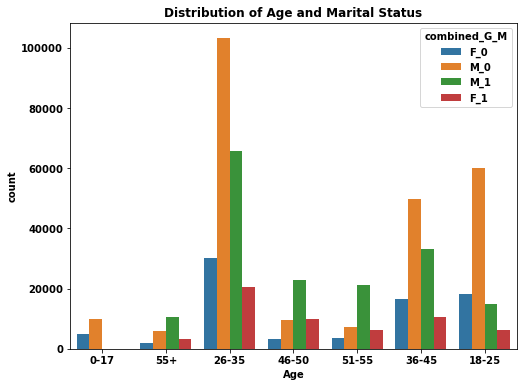

In [22]:
fig = plt.figure(figsize=[8,6])
sns.countplot(df['Age'], hue=df['combined_G_M'])
plt.title('Distribution of Age and Marital Status')
plt.savefig('./Images/age_marital.png')

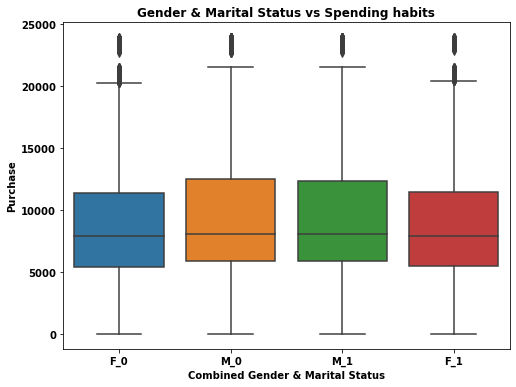

In [24]:
plt.figure(figsize=[8,6])
sns.boxplot(x='combined_G_M', y='Purchase', data=df);
plt.xlabel('Combined Gender & Marital Status')
plt.title('Gender & Marital Status vs Spending habits');
plt.savefig('./Images/gender_marital_spending.png')

Spending is highest among male men and lowest among single females. This can be attributed to the fact that single females are probably dating and their boyfriends do purchase for them. On the other hand, married men are obliged to spend on behalf of their wives.

In [25]:
df.head(2)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,combined_G_M
0,1000001,P00069042,F,0-17,10,A,2,0,3,9999.0,9999.0,8370,F_0
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200,F_0


In [26]:
df['combined_Gender_Age'] = df.apply(lambda x: '%s_%s' % (x['Gender'], x['Age']), axis=1)

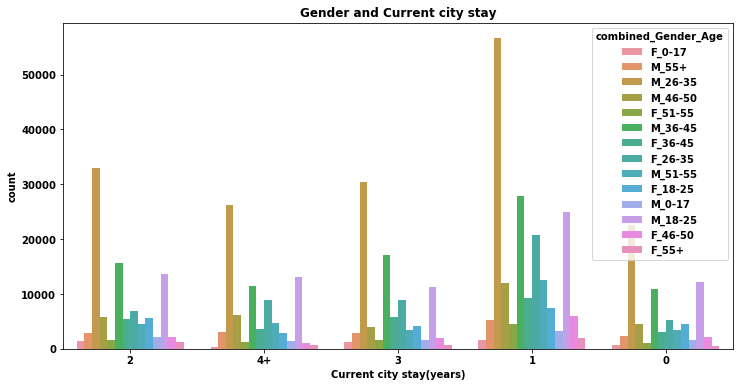

In [29]:
plt.figure(figsize=[12,6])
sns.countplot(df['Stay_In_Current_City_Years'], hue=df['combined_Gender_Age']);
plt.xlabel('Current city stay(years)')
plt.title('Gender and Current city stay');

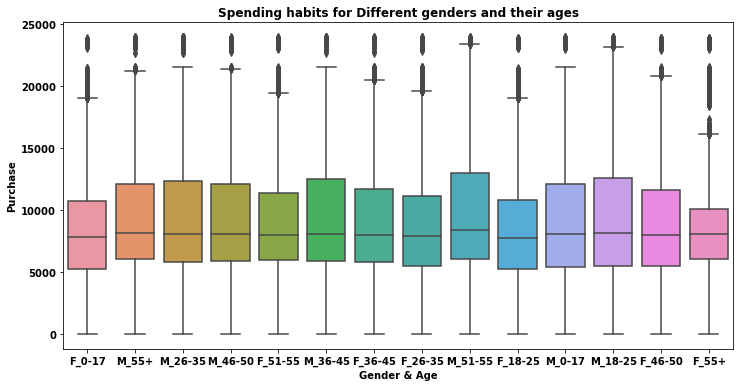

In [32]:
fig = plt.figure(figsize=[12, 6])
sns.boxplot(x='combined_Gender_Age', y='Purchase', data=df);
plt.xlabel('Gender & Age')
plt.title('Spending habits for Different genders and their ages');
plt.savefig('./Images/gender_age_spending.png')

It's expected that customers of the same gender and age group would not differ much in their spending habits on a black friday. However, disparities can be seen where male of ages between 0-17 purchased more than their female counterparts. Females aged 55 years and over did purchase more on average compared to their male counterparts. More outliers can be seen under purchases made by females aged 55+.

In [33]:
df['combined_Marital_Age'] = df.apply(lambda x: '%s_%s' % (x['Marital_Status'], x['Age']), axis=1)

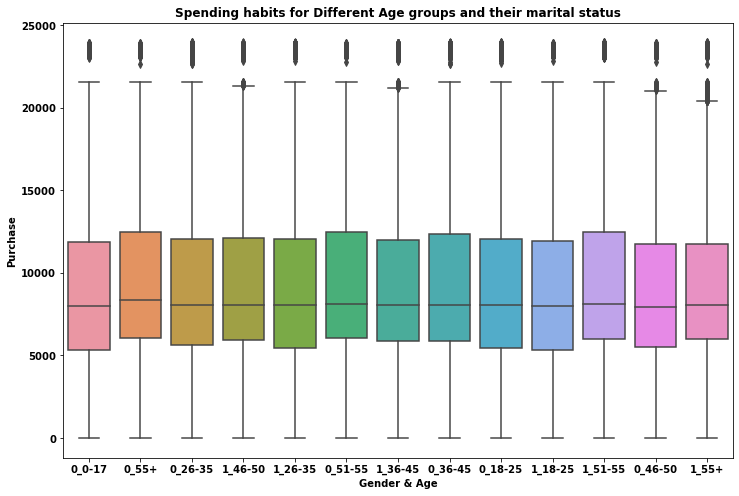

In [35]:
fig = plt.figure(figsize=[12,8])
sns.boxplot(x='combined_Marital_Age', y='Purchase', data=df);
plt.xlabel('Gender & Age')
plt.title('Spending habits for Different Age groups and their marital status');
plt.savefig('./Images/marital_age_spending.png')

## Feature Engineering

In [36]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,9999.0,9999.0,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,9999.0,9999.0,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,9999.0,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,9999.0,9999.0,7969


In [37]:
train.Product_Category_3.value_counts()

9999.0    383247
16.0       32636
15.0       28013
14.0       18428
17.0       16702
5.0        16658
8.0        12562
9.0        11579
12.0        9246
13.0        5459
6.0         4890
18.0        4629
4.0         1875
11.0        1805
10.0        1726
3.0          613
Name: Product_Category_3, dtype: int64

In [38]:
label_encoder = LabelEncoder()

In [39]:
cat_vars = ['Occupation','City_Category','Stay_In_Current_City_Years']
def engineer_features(df):
    
    """engineer_features function transforms characters in categorical variables Gender and Age into numbers
    
    Args:
        df: pandas dataframe
        
    Returns:
        df: transformed pandas dataframe
    
    """
    df['Gender'] = df['Gender'].map({'M':1, 'F':0})
    df['Age'] =label_encoder.fit_transform(df['Age'])
    df['Product_ID'] = label_encoder.fit_transform(df['Product_ID'])
    for col in cat_vars:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)
        except:
            continue
    return df

train = engineer_features(train)
test = engineer_features(test)

In [40]:
#Divide data into train and test sets
X = train.drop(['User_ID', 'Purchase'], axis=1)
y = train['Purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
linear_model = LinearRegression(normalize=True)

In [42]:
linear_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [43]:
pred_train = linear_model.predict(X_train)
pred_test = linear_model.predict(X_test)

In [44]:
print("RSME Train: {}".format(np.sqrt(mean_squared_error(y_train, pred_train))))
print("RSME Test: {}".format(np.sqrt(mean_squared_error(y_test, pred_test))))

RSME Train: 4596.03285884316
RSME Test: 4599.297935727064


## Lasso Regression

In [45]:
lasso_reg = Lasso(normalize=True)

In [46]:
lasso_reg.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [47]:
pred_train = lasso_reg.predict(X_train)
pred_test = lasso_reg.predict(X_test)

In [48]:
print('RMSE Train: {}'.format(np.sqrt(mean_squared_error(y_train, pred_train))))
print('RMSE Test: {}'.format(np.sqrt(mean_squared_error(y_test, pred_test))))

RMSE Train: 4685.596936264395
RMSE Test: 4686.478068149159


## Random Forest

In [49]:
rf_model = RandomForestRegressor()

In [50]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [51]:
pred_train = rf_model.predict(X_train)
pred_test = rf_model.predict(X_test)

In [52]:
print('RMSE Train: {}'.format(np.sqrt(mean_squared_error(y_train, pred_train))))
print('RMSE Test: {}'.format(np.sqrt(mean_squared_error(y_test, pred_test))))

RMSE Train: 1415.658413647532
RMSE Test: 2982.833024109688


In [53]:
# RF with tunned parameters
parameters = {'n_estimators':[17, 18, 19],
             'max_depth': [12],
             'min_samples_split': [2]}

grid_obj = GridSearchCV(rf_model, parameters, cv=5)

In [54]:
grid_fit = grid_obj.fit(X_train, y_train)

In [55]:
best_rf = grid_fit.best_estimator_

In [56]:
best_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [57]:
pred_train = best_rf.predict(X_train)
pred_test = best_rf.predict(X_test)

print('RMSE Train: {}'.format(np.sqrt(mean_squared_error(y_train, pred_train))))
print('RMSE Test: {}'.format(np.sqrt(mean_squared_error(y_test, pred_test))))

RMSE Train: 2651.063557793122
RMSE Test: 2748.3797422206158
